## Popular Algorithmic Trading Strategies:

### **Trend Following**: Capitalizes on rising or falling trends. You can use moving averages (e.g., simple moving average (SMA), exponential moving average (EMA)) or trend following indicators (e.g., average true range (ATR)) to identify trends and generate buy/sell signals.<br><br>


### **Mean Reversion**: Assumes prices eventually revert to their historical average. Strategies involve identifying periods of high volatility followed by corrections. Bollinger Bands or standard deviation can be used to measure volatility.<br><br>


### **Statistical Arbitrage**: Exploits temporary price discrepancies between correlated assets. Requires complex algorithms to identify and exploit these  inefficiencies.

### ***Trend Following***

[*********************100%%**********************]  1 of 1 completed


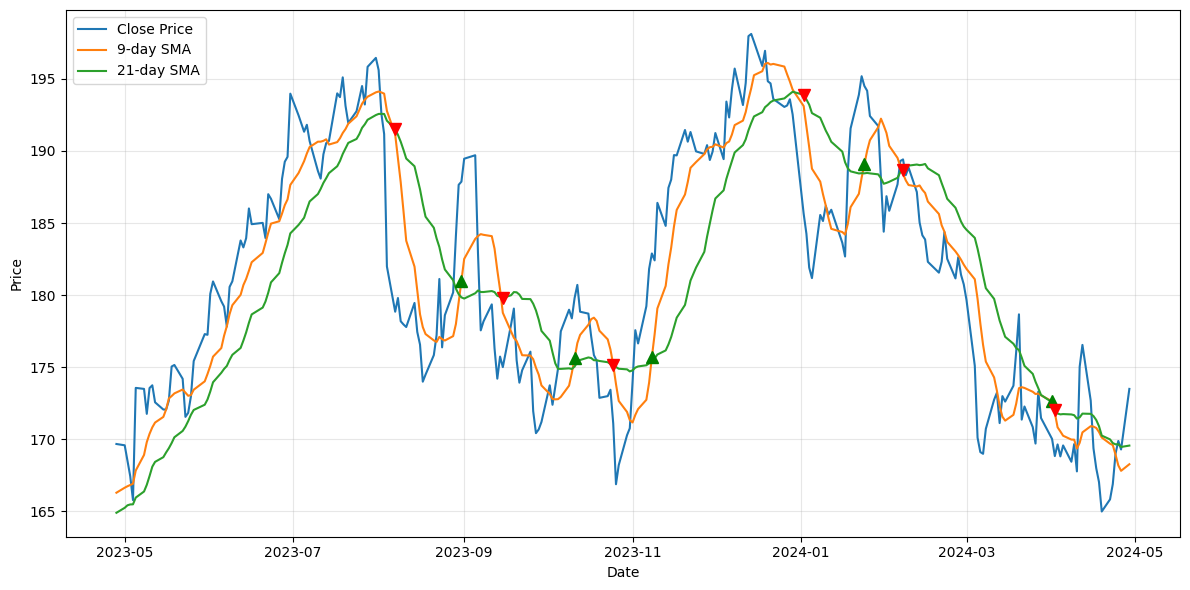

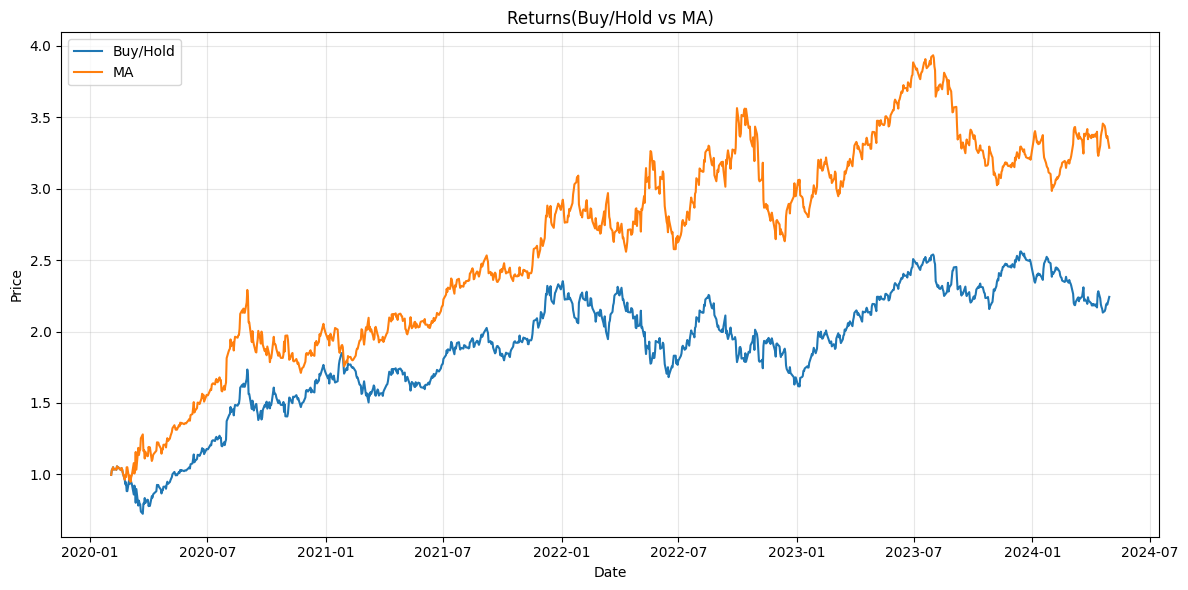

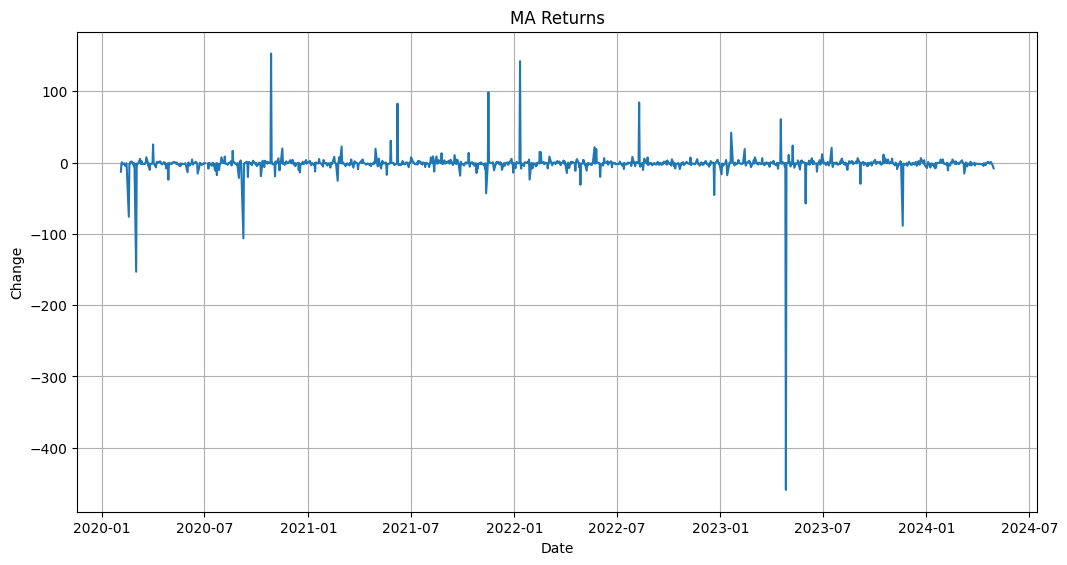

In [171]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

ticker = "AAPL"
short_window = 9
long_window = 21

data = yf.download(ticker, start='2020-01-01', end='2024-04-30')

data["Short_MA"] = data["Close"].rolling(window=short_window).mean()
data["Long_MA"] = data["Close"].rolling(window=long_window).mean()

data['Signal'] = np.where(data["Short_MA"] > data["Long_MA"], 1, 0)
data['Signal'] = np.where(data['Short_MA'] < data["Long_MA"], -1, data['Signal'])
data.dropna(inplace=True)

data['entry'] = data.Signal.diff()

# Plot 1: Close Price and SMA
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(data.iloc[-252:]['Close'], label = 'Close Price')
plt.plot(data.iloc[-252:]['Short_MA'], label = f"{short_window}-day SMA")
plt.plot(data.iloc[-252:]['Long_MA'], label = f"{long_window}-day SMA")
plt.plot(data[-252:].loc[data.entry == 2].index, data[-252:]['Short_MA'][data.entry == 2], '^',
         color = 'g', markersize = 8)
plt.plot(data[-252:].loc[data.entry == -2].index, data[-252:]['Long_MA'][data.entry == -2], 'v',
         color = 'r', markersize = 8)
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.legend(loc=2)
plt.show()

# Returns
data['Return'] = np.log(data['Close']).diff()
data['MA_Return'] = data['Signal'] * data['Return']

#Plot 2: Returns
plt.plot(np.exp(data['Return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(data['MA_Return']).cumprod(), label='MA')
plt.legend(loc=2)
plt.title("Returns(Buy/Hold vs MA)")
plt.grid(True, alpha=.3)
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

#Plot 3: Std Dev
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(data['MA_Return'].pct_change())
plt.title("MA Returns")
plt.xlabel("Date")
plt.ylabel("Change")
plt.grid(True)

### **Risk**

In [172]:
a = data['MA_Return'].std()
a

0.020709207826095307

### **Mean Reversion**

[*********************100%%**********************]  1 of 1 completed


/tmp/ipykernel_8557/1201117586.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


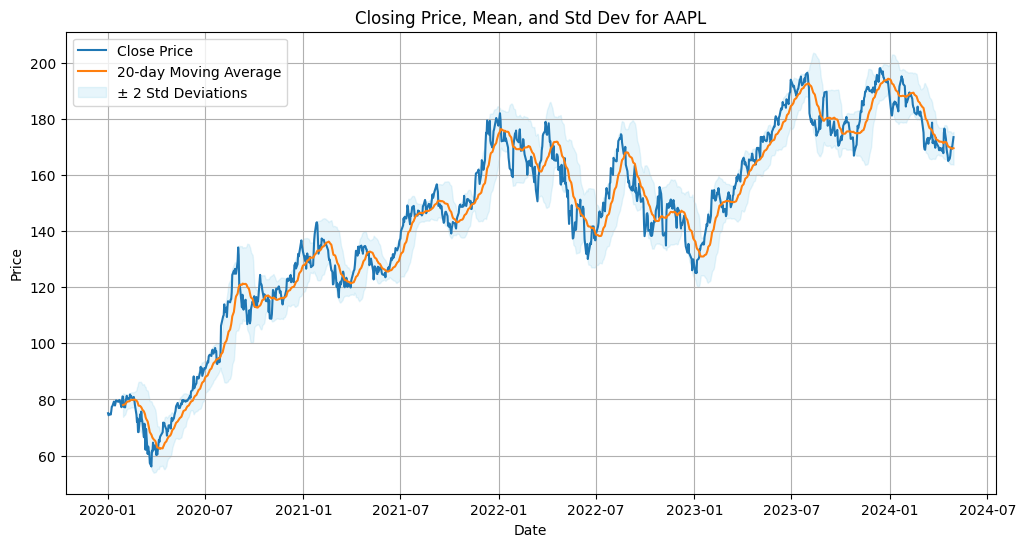

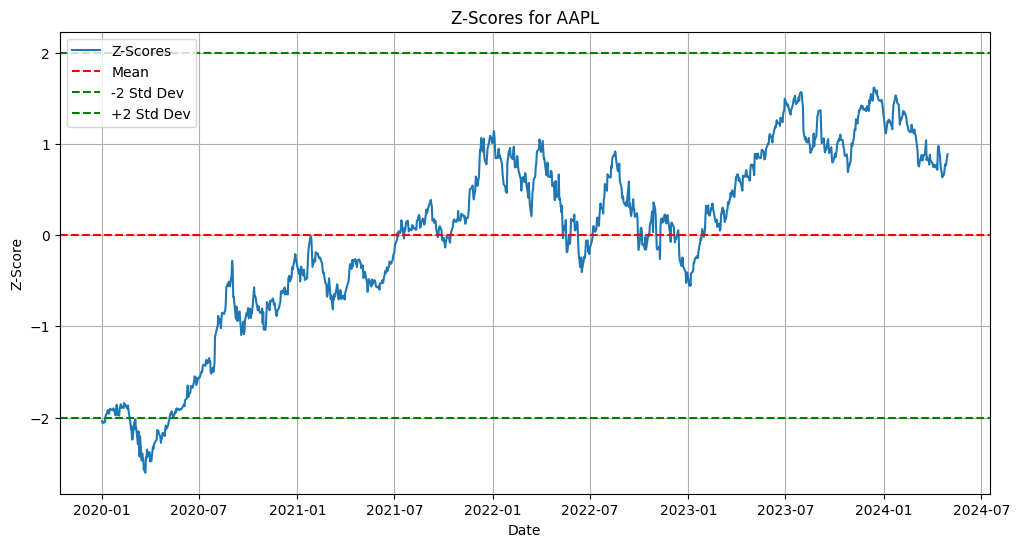

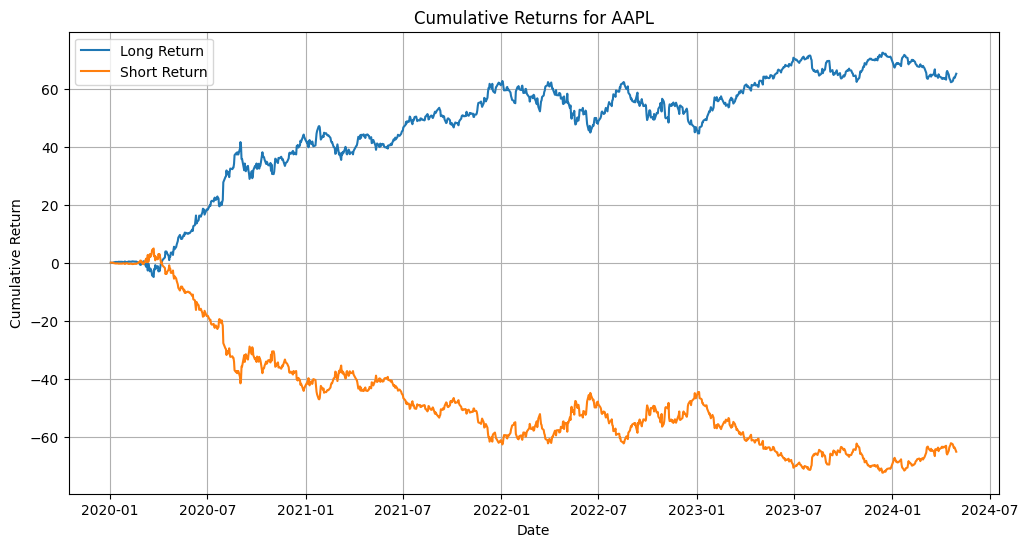

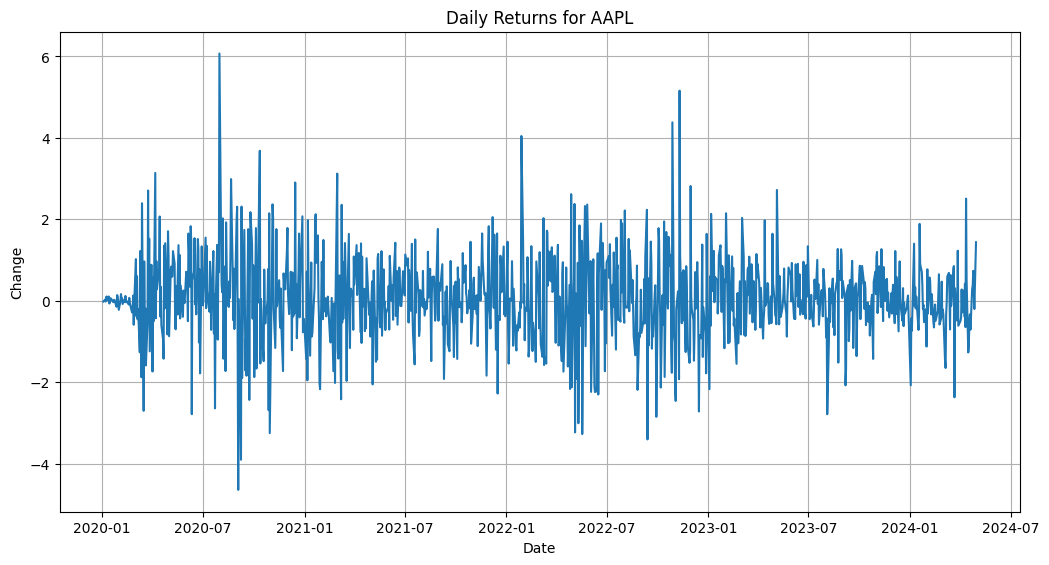

In [173]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

symbol = "AAPL"
num_std = 2

data = yf.download(symbol, start='2020-01-01', end='2024-04-30')


data["Std"] = data["Close"].rolling(window=20).std()
data["Mean"] = data["Close"].rolling(window=20).mean()

data["Z_Score"] = zscore(data["Close"])

data["Signal"] = 0
data.loc[data["Z_Score"] < -num_std, "Signal"] = 1
data.loc[data["Z_Score"] > num_std, "Signal"] = -1

data["Daily_Return"] = data["Close"].pct_change()

data["Long_Return"] = data["Daily_Return"] * data["Signal"].cumsum().fillna(0)
data["Short_Return"] = data["Daily_Return"] * (-1 * data["Signal"].cumsum().fillna(0))

#Plot 1: Closing Price, Mean, and Std Dev
plt.figure(figsize=(12, 6))
plt.plot(data["Close"], label="Close Price")
plt.plot(data["Mean"], label="20-day Moving Average")
plt.fill_between(data.index, data["Mean"] + num_std * data["Std"], data["Mean"] - num_std * data["Std"], alpha=0.2, color="skyblue", label="± 2 Std Deviations")
plt.legend()
plt.title(f"Closing Price, Mean, and Std Dev for {symbol}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)

# Plot 2: Z-Scores
plt.figure(figsize=(12, 6))
plt.plot(data["Z_Score"], label="Z-Scores")
plt.axhline(y=0, color='r', linestyle='--', label='Mean')
plt.axhline(y=-num_std, color='g', linestyle='--', label=f'-{num_std} Std Dev')
plt.axhline(y=num_std, color='g', linestyle='--', label=f'+{num_std} Std Dev')
plt.legend()
plt.title(f"Z-Scores for {symbol}")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.grid(True)

# Plot 3: Cumulative Returns (Long and Short)
plt.figure(figsize=(12, 6))
plt.plot(data["Long_Return"].cumsum(), label="Long Return")
plt.plot(data["Short_Return"].cumsum(), label="Short Return")
plt.legend()
plt.title(f"Cumulative Returns for {symbol}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)

# Calculate total returns
total_long_return = (data["Long_Return"] + 1).prod() - 1
total_short_return = (data["Short_Return"] + 1).prod() - 1

#Plot 4: Daily Returns
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(data['Long_Return'])
plt.title(f"Daily Returns for {symbol}")
plt.xlabel("Date")
plt.ylabel("Change")
plt.grid(True)

plt.tight_layout()
plt.show()


### **Risk**

In [174]:
b = data["Long_Return"].std()
b

1.0547507980680046

### **Statistical Arbitrage**

[*********************100%%**********************]  2 of 2 completed


Assets are not cointegrated. Statistical arbitrage strategy might not be suitable.


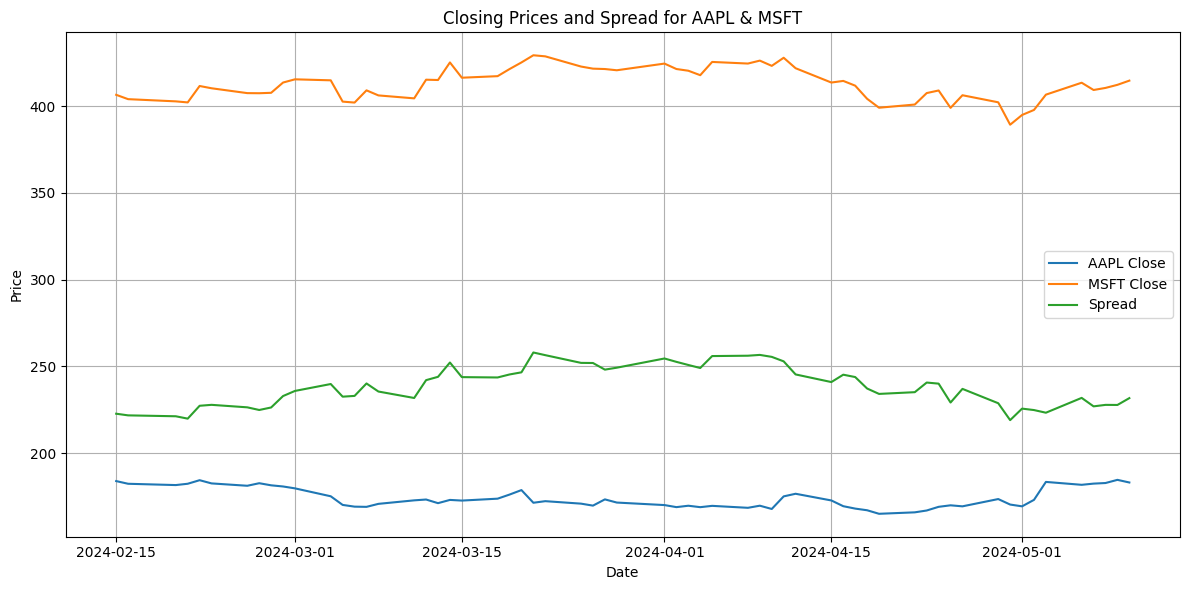

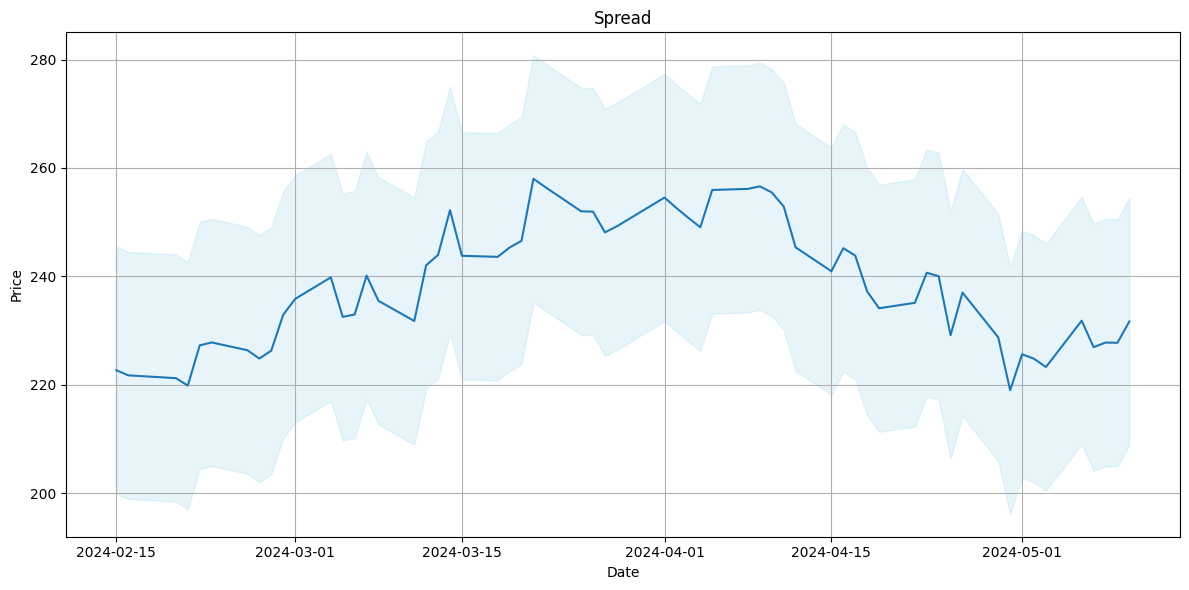

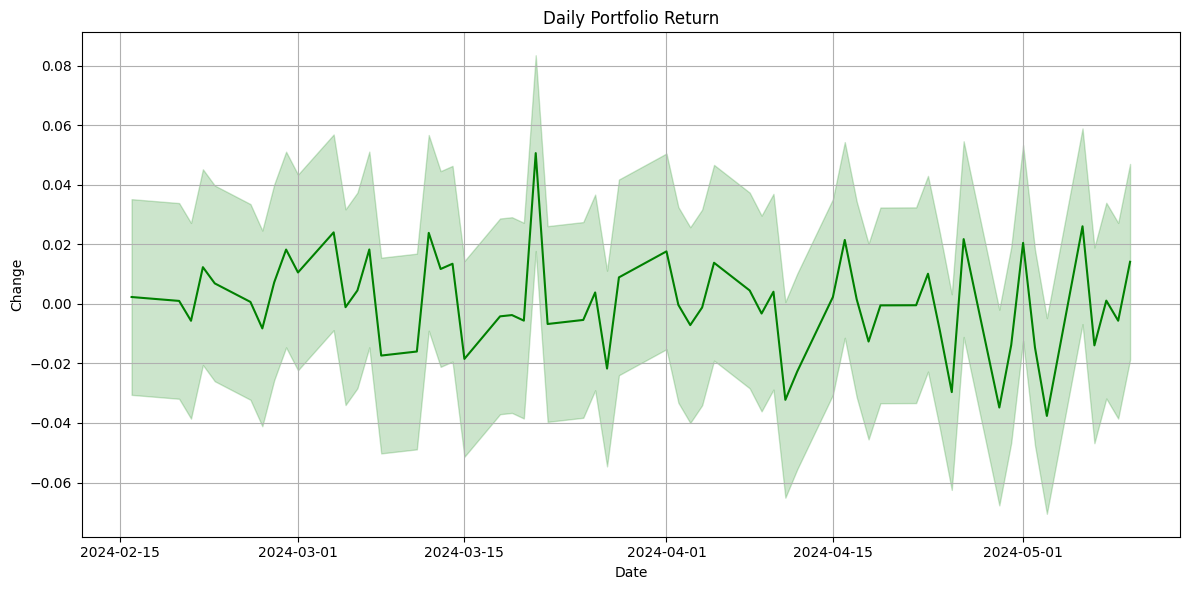

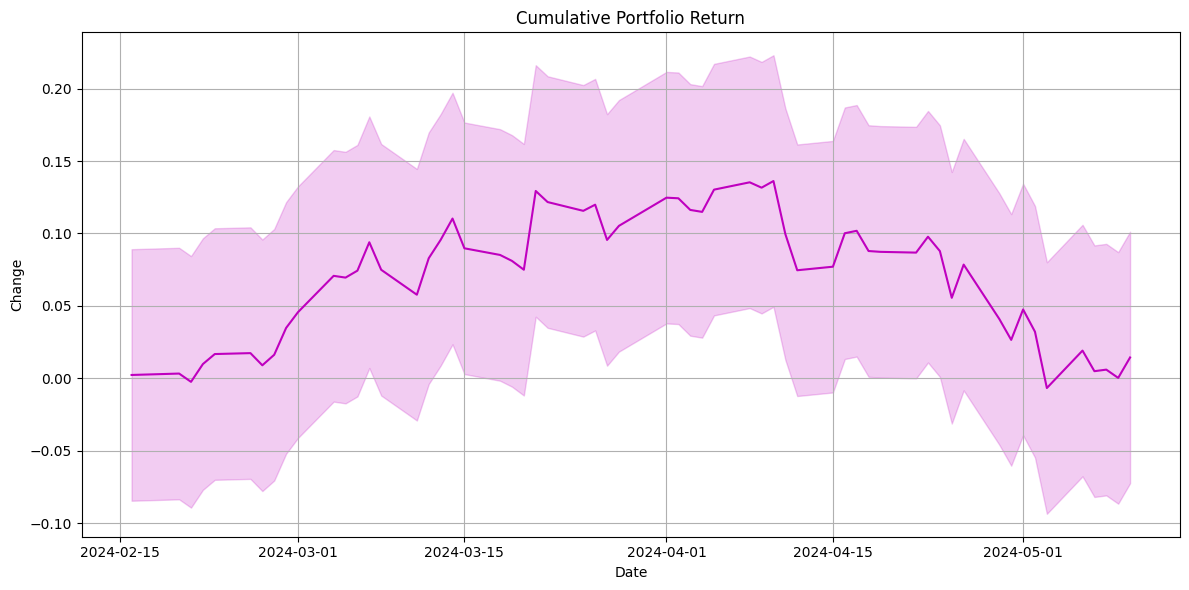

In [175]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller

# Define symbols, lookback period, and significance level (alpha) for cointegration test
symbol1 = "AAPL"
symbol2 = "MSFT"
lookback = 60
alpha = 0.05  # Significance level for cointegration test

# Download historical data
data = yf.download([symbol1, symbol2], period=f"{lookback}d")


# Calculate spread (difference in closing prices)
data["Spread"] = data['Close'][symbol2] - data['Close'][symbol1]  # All instances changed

# Calculate rolling mean and standard deviation of the spread
x = data['Spread'].std()

# Perform Augmented Dickey-Fuller (ADF) test for stationarity
def is_stationary(series):
  """
  Performs Augmented Dickey-Fuller (ADF) test for stationarity.
  Returns True if the p-value is less than alpha, indicating stationarity.
  """
  adf_test = adfuller(series)
  p_value = adf_test[0]
  return p_value < alpha

# Check stationarity for both time series
stationary1 = is_stationary(data['Close'][symbol1])  # All instances changed
stationary2 = is_stationary(data['Close'][symbol2])  # All instances changed

# Perform Engle-Granger cointegration test
def is_cointegrated(series1, series2):
  """
  Performs Engle-Granger cointegration test.
  Returns True if the p-value is less than alpha, indicating cointegration.
  """
  coint_test = coint(series1, series2)
  p_value = coint_test[1]
  return p_value < alpha

# Check cointegration if both series are stationary
if stationary1 and stationary2:
  cointegrated = is_cointegrated(data['Close'][symbol1], data['Close'][symbol2])  # All instances changed
  if cointegrated:
    print("Assets are cointegrated. Statistical arbitrage strategy might be applicable.")
  else:
    print("Assets are not cointegrated. Statistical arbitrage strategy might not be suitable.")
else:
  print(f"One or both time series are not stationary. Cointegration test not performed.")

# Calculate daily returns (assuming 1 share for each asset)
data["Daily_Return1"] = data['Close'][symbol1].pct_change()  # All instances changed
data["Daily_Return2"] = data['Close'][symbol2].pct_change()  # All instances changed

# Basic strategy (replace with your trading logic based on cointegration and spread deviations)
# This example assumes you buy asset 1 (AAPL) when spread is below -2 standard deviations and sell
# when it's above +2 standard deviations. You short asset 2 (MSFT) with opposite positions.
data["Signal"] = 0
data.loc[data["Spread"] < -2 * x, "Signal"] = 1  # Long asset 1, short asset 2
data.loc[data["Spread"] > 2 * x, "Signal"] = -1  # Short asset 1, long asset 2

# Calculate daily portfolio return based on the signal and daily returns
data["Daily_Portfolio_Return"] = data["Signal"] * (data["Daily_Return1"] - data["Daily_Return2"])

# Calculate cumulative portfolio return
data["Cumulative_Portfolio_Return"] = (data["Daily_Portfolio_Return"] + 1).cumprod() - 1

# Plot closing prices and spread (optional)
plt.figure(figsize=(12, 6))
plt.plot(data["Close"][symbol1], label=f"{symbol1} Close")
plt.plot(data["Close"][symbol2], label=f"{symbol2} Close")
plt.plot(data["Spread"], label="Spread")
plt.legend()
plt.title(f"Closing Prices and Spread for {symbol1} & {symbol2}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot spread
plt.figure(figsize=(12, 6))
plt.plot(data["Spread"], label="Spread")
plt.fill_between(data.index, data["Spread"] + 2 * x, data["Spread"] - 2 * x, alpha=0.2, color="skyblue")
plt.title('Spread')
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot Daily Portfolio Return
plt.plot(data["Daily_Portfolio_Return"],color='g')
plt.fill_between(data.index, data["Daily_Portfolio_Return"] + 2 * data["Daily_Portfolio_Return"].std(), data["Daily_Portfolio_Return"] - 2 * data["Daily_Portfolio_Return"].std(), alpha=0.2, color="g")
plt.title('Daily Portfolio Return')
plt.xlabel("Date")
plt.ylabel("Change")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Cumulative Portfolio Return
plt.plot(data["Cumulative_Portfolio_Return"],color='m')
plt.fill_between(data.index, data["Cumulative_Portfolio_Return"] + 2 * data["Cumulative_Portfolio_Return"].std(), data["Cumulative_Portfolio_Return"] - 2 * data["Cumulative_Portfolio_Return"].std(), alpha=0.2, color="m")
plt.title('Cumulative Portfolio Return')
plt.xlabel("Date")
plt.ylabel("Change")
plt.grid(True)
plt.tight_layout()
plt.show()


### **Risk**

In [176]:
c = data["Daily_Portfolio_Return"].std()
c

0.0164260206059693

## Conclusion

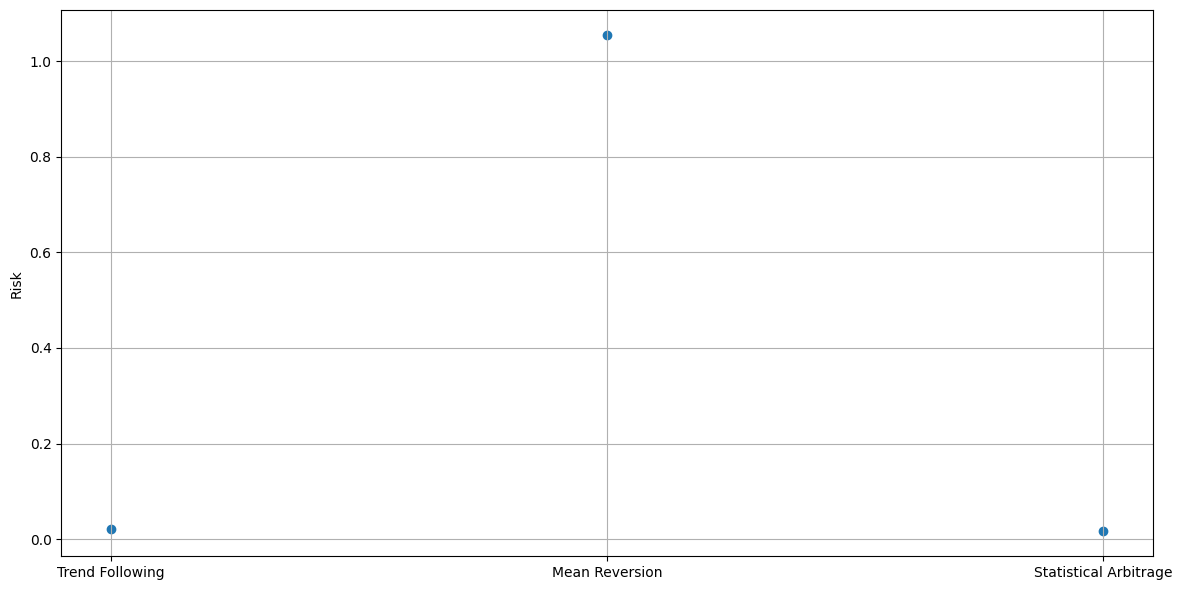

In [177]:
plt.scatter(['Trend Following','Mean Reversion', 'Statistical Arbitrage'],[a,b,c])
plt.ylabel("Risk")
plt.grid(True)
plt.tight_layout()
plt.show()